<h2 align='center'>Linear Regression - Bike sharing assignment</h2>

Problem Statement:
Understand the variables which helps increase the revenue and recover from dips
1) Which variables are significant in predicting the demand for shared bikes.
2) How well those variables describe the bike demands

### Task 1: Import Libraries & Datasets

In [426]:
# Core modules
import pandas as pd
import numpy as np

# Basic modules for data visualization
import seaborn as sns
from scipy.stats import skew
%matplotlib inline
sns.set(style='ticks', palette='Set2')

In [433]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Model Building
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error, r2_score


# Custom functions
def find_r2(X, y, features):
    model = LinearRegression().fit(X[features], y)
    r2score = r2_score(y, model.predict(X[features]))
    print("R^2: ", r2score, features)
    print("adjusted R^2: ", 1 - ((1 - r2score)* ((X.shape[0])/(X.shape[0]-1-len(features)))))
    print("__________________________________________________________________")

def build_lm(df, y, features):
    training_data = sm.add_constant(df[features])
    model = sm.OLS(y, training_data).fit()
    return model


In [490]:
# read csv file
bikes = pd.read_csv("day.csv")

bikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Task 2: Exploratory Data Analysis

In [491]:
# Lets drop instant which adds no value.
bikes.drop('instant', axis=1, inplace=True)
bikes.drop('dteday', axis=1, inplace=True) # dropping this because we have year and month columns already and its not that useful
# Removing casual and registered which are highly corelated with output  variable and they are duplicates of cnt.
bikes.drop('casual', axis=1, inplace=True)
bikes.drop('registered', axis=1, inplace=True)
# dropping highly corelated atemp variable.
bikes.drop('atemp', axis=1, inplace=True)
# workingday and holiday are similar
bikes.drop('workingday', axis=1, inplace=True)

In [492]:

# Also as we are using linear regression. its better we convert this into one hot encoding.
def map_seasons(x):
    return x.map({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'})
bikes[['season']] = bikes[['season']].apply(map_seasons)

def map_mnths(x):
    return x.map({1: 'January',2: 'February',3: 'March',4: 'April',5: 'May',6: 'June',7: 'July',8: 'August',9: 'September',10: 'October',11: 'November',12: 'December'})
bikes[['mnth']] = bikes[['mnth']].apply(map_mnths)

def map_weekdays(x):
    return x.map({1: 'monday', 2: 'tuesday', 3: 'wednesday', 4: 'thursday', 5: 'friday', 6: 'saturday', 0: 'sunday'})
bikes[['weekday']] = bikes[['weekday']].apply(map_weekdays)

def map_weathersit(x):
    return x.map({1: 'clear', 2: 'mist', 3: 'snow', 4: 'rainy'})
bikes[['weathersit']] = bikes[['weathersit']].apply(map_weathersit)

<AxesSubplot:xlabel='season', ylabel='cnt'>

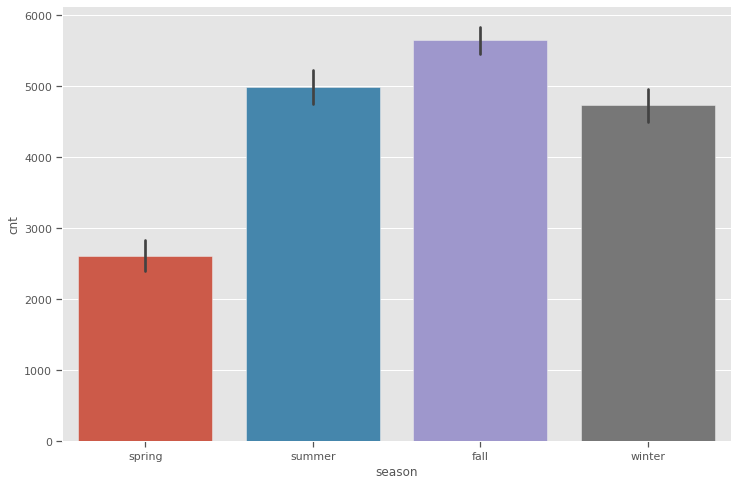

In [437]:
sns.barplot(x='season',y='cnt',data=bikes)

<AxesSubplot:xlabel='mnth', ylabel='cnt'>

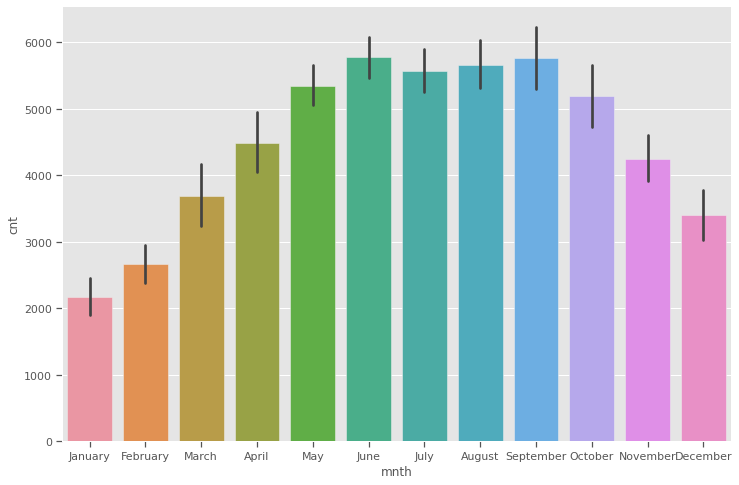

In [438]:
sns.barplot(x='mnth',y='cnt',data=bikes)

> From both month and season feature observations, it seems more and more users are coming in the middle of year
-  Including any one of the feature is enough for the model as both of them denotes the same thing. Its better to take season variables into model as they are more broad.

<AxesSubplot:xlabel='weekday', ylabel='cnt'>

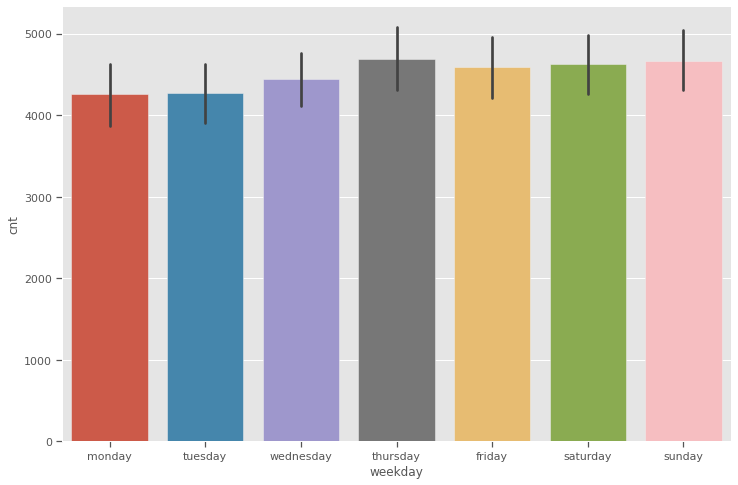

In [439]:
sns.barplot(x='weekday',y='cnt',data=bikes)

<AxesSubplot:xlabel='weathersit', ylabel='cnt'>

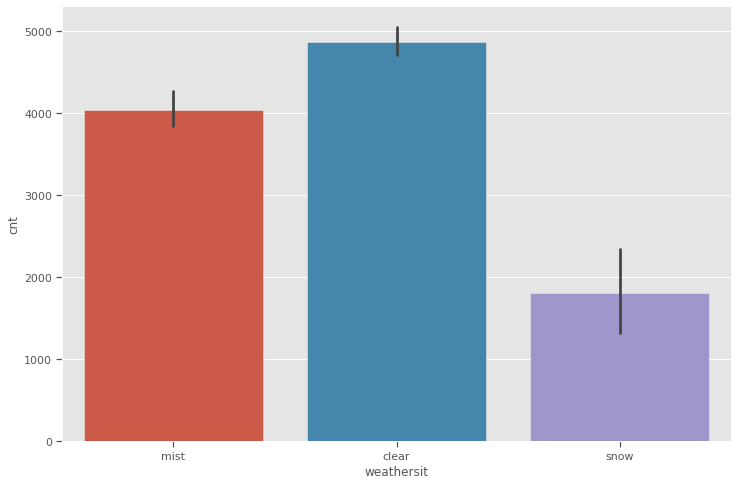

In [440]:
sns.barplot(x='weathersit',y='cnt',data=bikes)

> From this we can assume that weathersit_snow is right feature for the model as it explains the drastic decrease in the count

In [494]:
bikes = pd.get_dummies(bikes, columns=['season'], drop_first=True)
# season and month are similar as per graphs above.
bikes.drop('mnth', axis=1, inplace=True)
# weekday wont explain much of the output.
bikes.drop('weekday', axis=1, inplace=True)
bikes = pd.get_dummies(bikes, columns=['weathersit'], drop_first=True)

In [495]:
bikes.shape

(730, 11)

In [496]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   yr               730 non-null    int64  
 1   holiday          730 non-null    int64  
 2   temp             730 non-null    float64
 3   hum              730 non-null    float64
 4   windspeed        730 non-null    float64
 5   cnt              730 non-null    int64  
 6   weathersit_mist  730 non-null    uint8  
 7   weathersit_snow  730 non-null    uint8  
 8   season_spring    730 non-null    uint8  
 9   season_summer    730 non-null    uint8  
 10  season_winter    730 non-null    uint8  
dtypes: float64(3), int64(3), uint8(5)
memory usage: 37.9 KB


We have our supervised learning model in place because we already have our data. 
This is a regression task

- Target variable is continuous, so its a regression task.
- This is small dataset based on the record count
- From this I've observed, no missing values because the total count and non-null values are same
- Most of the conversions are already happened and clean dataset
- Most of the data is in numericals
- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands

In [497]:
# Check the null values
bikes.isnull().sum()

yr                 0
holiday            0
temp               0
hum                0
windspeed          0
cnt                0
weathersit_mist    0
weathersit_snow    0
season_spring      0
season_summer      0
season_winter      0
dtype: int64

In [498]:
# Check information
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   yr               730 non-null    int64  
 1   holiday          730 non-null    int64  
 2   temp             730 non-null    float64
 3   hum              730 non-null    float64
 4   windspeed        730 non-null    float64
 5   cnt              730 non-null    int64  
 6   weathersit_mist  730 non-null    uint8  
 7   weathersit_snow  730 non-null    uint8  
 8   season_spring    730 non-null    uint8  
 9   season_summer    730 non-null    uint8  
 10  season_winter    730 non-null    uint8  
dtypes: float64(3), int64(3), uint8(5)
memory usage: 37.9 KB


In [499]:
# Statistics summary - Descriptive
bikes.describe()

,yr,holiday,temp,hum,windspeed,cnt,weathersit_mist,weathersit_snow,season_spring,season_summer,season_winter
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.500000,0.028767,20.319259,62.765175,12.763620,4508.006849,0.336986,0.028767,0.246575,0.252055,0.243836
std,0.500343,0.167266,7.506729,14.237589,5.195841,1936.011647,0.473004,0.167266,0.431313,0.434490,0.429689
min,0.000000,0.000000,2.424346,0.000000,1.500244,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,13.811885,52.000000,9.041650,3169.750000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.000000,20.465826,62.625000,12.125325,4548.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,26.880615,72.989575,15.625589,5966.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,35.328347,97.250000,34.000021,8714.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [500]:
# Grouping by year
bikes.groupby(by='yr').mean()

,holiday,temp,hum,windspeed,cnt,weathersit_mist,weathersit_snow,season_spring,season_summer,season_winter
yr,,,,,,,,,,
0,0.027397,19.953263,64.366477,12.823977,3405.761644,0.339726,0.041096,0.246575,0.252055,0.243836
1,0.030137,20.685256,61.163873,12.703263,5610.252055,0.334247,0.016438,0.246575,0.252055,0.243836


In [501]:
# Grouping by season
bikes.groupby(by='season_spring').mean()

,yr,holiday,temp,hum,windspeed,cnt,weathersit_mist,weathersit_snow,season_summer,season_winter
season_spring,,,,,,,,,,
0,0.5,0.025455,22.977442,64.270024,12.232277,5129.692727,0.329091,0.030909,0.334545,0.323636
1,0.5,0.038889,12.197035,58.167024,14.387168,2608.411111,0.361111,0.022222,0.000000,0.000000


- we can see the drastic increase in sales from last year to this year.
- H1: This means we can assume/hypothesize more and more users are coming each year
- H1: Almost fifty percent of users are coming in spring season.


<AxesSubplot:>

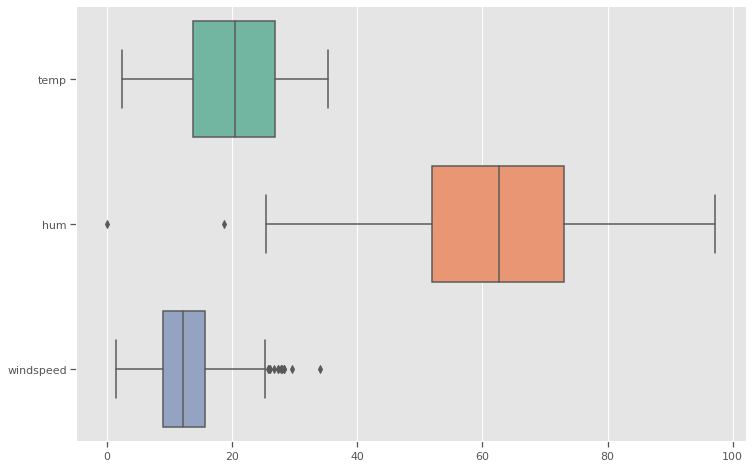

In [502]:
features = ['yr','holiday','temp','hum','windspeed','season_spring','season_summer','season_winter','weathersit_mist','weathersit_snow']
sns.boxplot(data=bikes[['temp', 'hum', 'windspeed']], orient="h", palette="Set2") # only using other than categorical variables

In [503]:
median = bikes.hum.describe().median()
bikes = bikes[bikes['hum'] > 15]

In [504]:
bikes.windspeed.describe() # valid values

count    729.000000
mean      12.757060
std        5.196382
min        1.500244
25%        9.041650
50%       12.125325
75%       15.624936
max       34.000021
Name: windspeed, dtype: float64

### Task 3: Data Visualization
Linear relationships b/w Features & Response

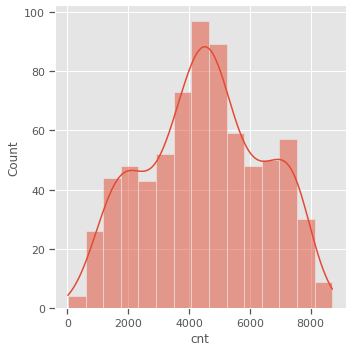

In [505]:
sns.displot(bikes['cnt'], kde=True)

- It clearly denotes there's no skewness on this target variable.
- No need to apply log transformations.

array([[<AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'hum'}>],
       [<AxesSubplot:title={'center':'windspeed'}>, <AxesSubplot:>]],
      dtype=object)

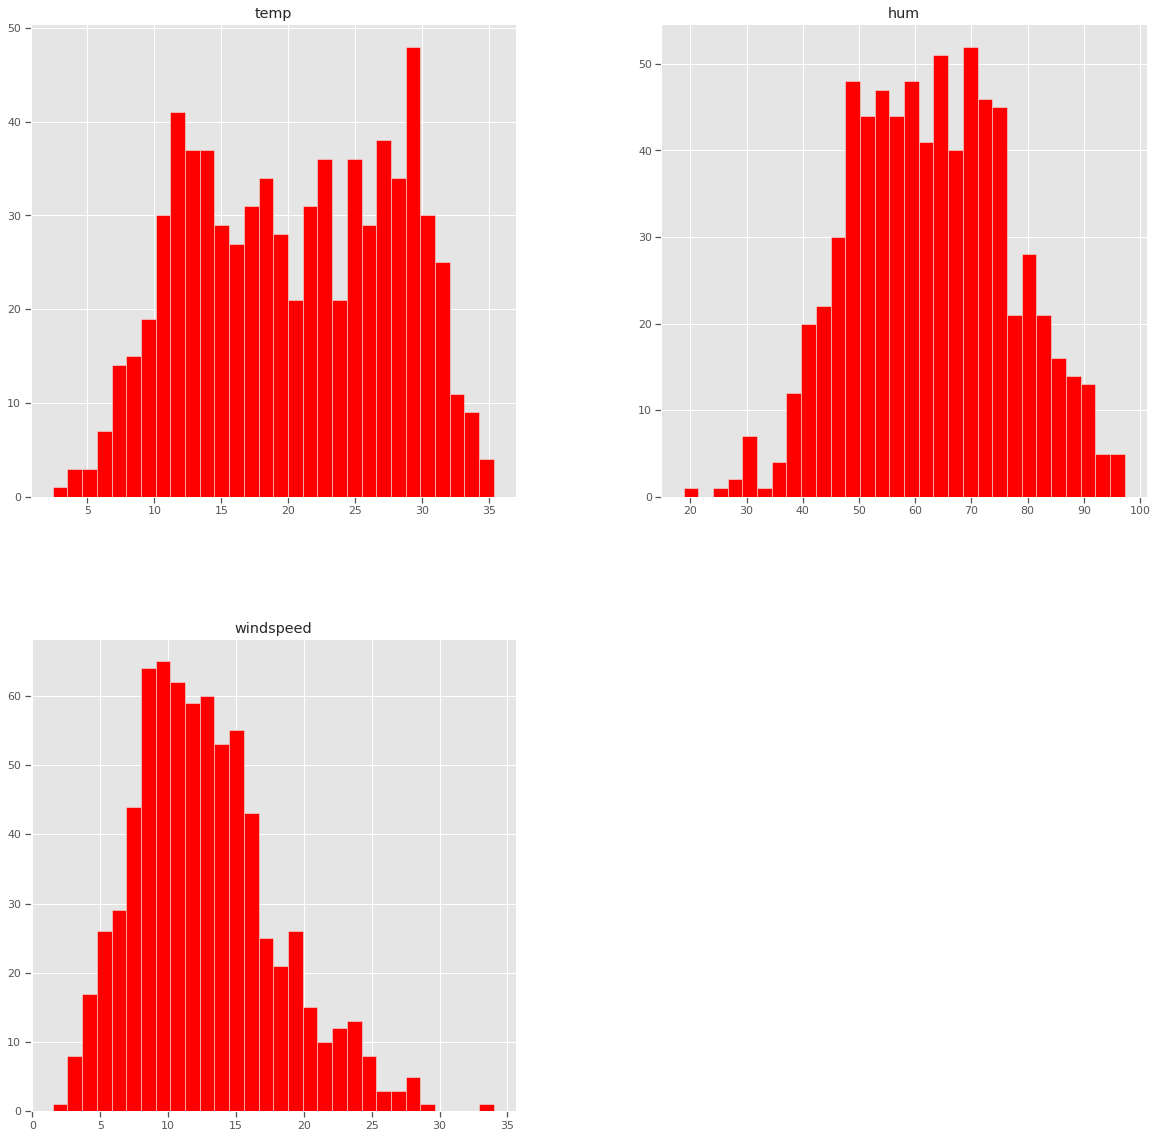

In [506]:
bikes[['temp', 'hum', 'windspeed']].hist(bins=30, figsize=(20,20), color='r')

- We see windspeed little skewness

###### Qualitative analysis
- temp explains the linearity

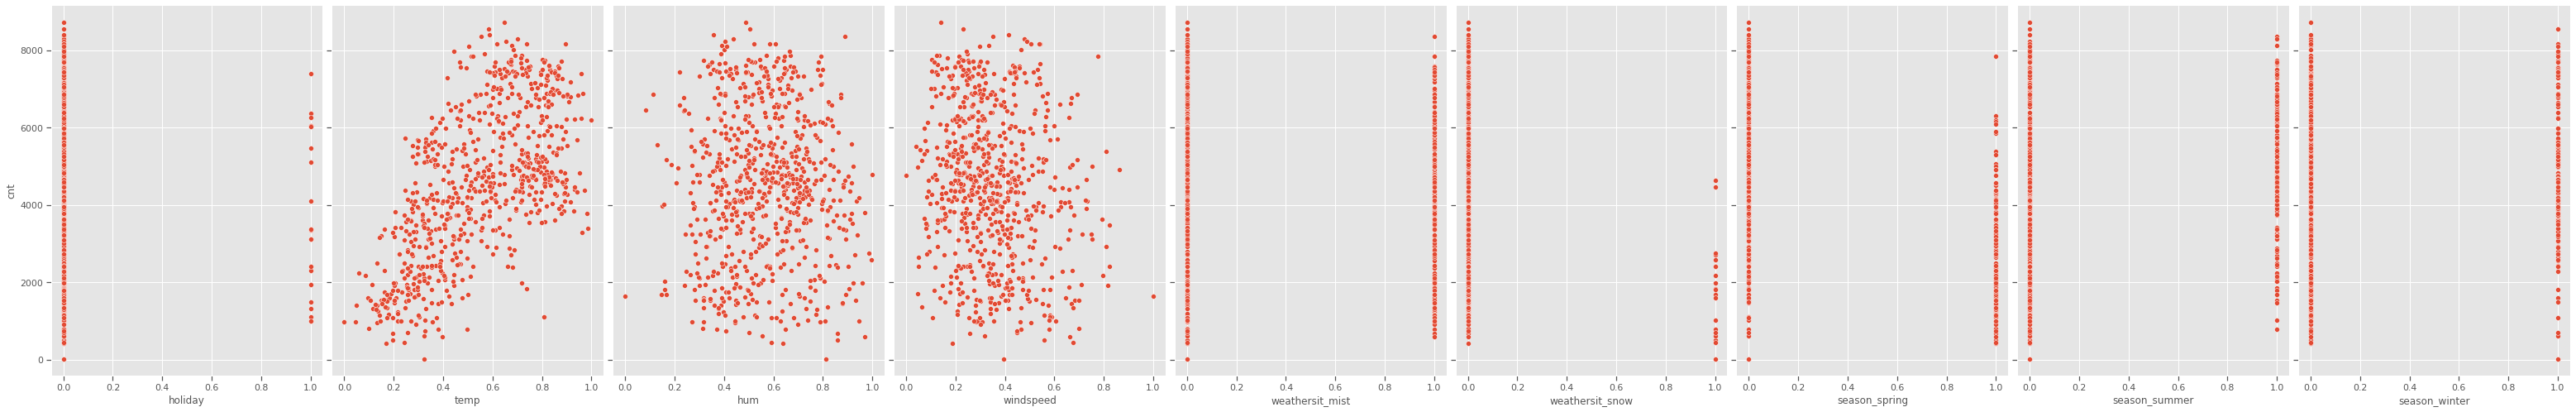

In [537]:
sns.pairplot(bikes, 
             x_vars=['holiday','temp','hum','windspeed','weathersit_mist','weathersit_snow','season_spring','season_summer','season_winter'],
             y_vars="cnt",
             height=7,
             aspect=0.7
            )

<AxesSubplot:>

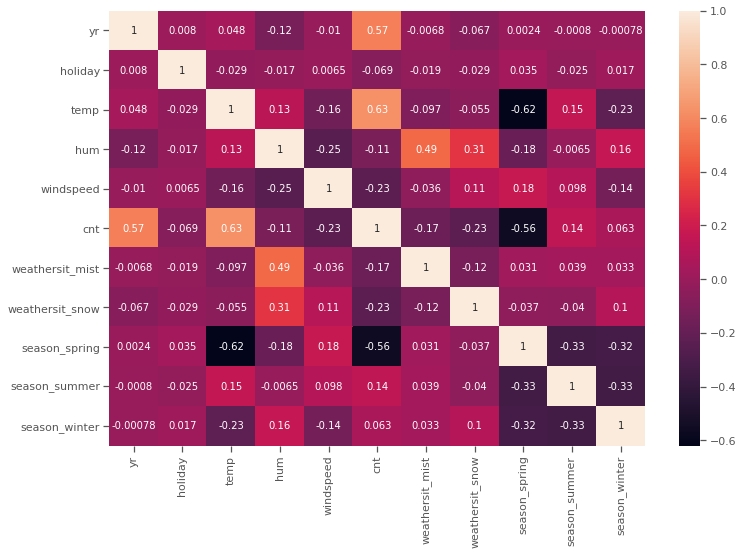

In [507]:
sns.heatmap(bikes.corr(), annot=True) # Corelation coefficient is independent of scaling

### Task 4: Feature Selection

In [508]:
scaling_features = ['temp', 'hum', 'windspeed']
scaler = MinMaxScaler()

bikes[scaling_features] = pd.DataFrame(scaler.fit_transform(bikes[scaling_features]))

In [509]:
bikes.head()

,yr,holiday,temp,hum,windspeed,cnt,weathersit_mist,weathersit_snow,season_spring,season_summer,season_winter
0,0,0,0.355170,0.787573,0.284606,985,1,0,1,0,0
1,0,0,0.379232,0.647694,0.466215,801,1,0,1,0,0
2,0,0,0.171000,0.317820,0.465740,1349,0,0,1,0,0
3,0,0,0.175530,0.513034,0.284297,1562,0,0,1,0,0
4,0,0,0.209120,0.317417,0.339143,1600,0,0,1,0,0


In [510]:
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(bikes[features], bikes.cnt, train_size = 0.7, test_size = 0.3, random_state = 100)

In [511]:
X_train.head()

,yr,holiday,temp,hum,windspeed,season_spring,season_summer,season_winter,weathersit_mist,weathersit_snow
626,1,0,0.607495,0.548592,0.197446,0,0,0,0,0
364,0,0,0.387359,0.643123,0.350001,1,0,0,0,0
426,1,0,0.332325,0.274561,0.643574,1,0,0,1,0
728,1,0,0.195259,0.496548,0.273062,1,0,0,0,0
482,1,0,0.497426,0.508762,0.194850,0,1,0,1,0


In [512]:
features = X_train[features]
target = y_train

# written common functions at top of declaration.
find_r2(features, target, ['temp'])
find_r2(features, target, ['temp', 'yr'])
find_r2(features, target, ['temp', 'yr', 'hum'])
find_r2(features, target, ['temp', 'yr', 'windspeed'])
find_r2(features, target, ['temp', 'yr', 'windspeed', 'weathersit_mist'])
find_r2(features, target, ['temp', 'yr', 'windspeed', 'weathersit_snow'])
find_r2(features, target, ['temp', 'yr', 'windspeed', 'weathersit_snow', 'season_spring'])
find_r2(features, target, ['temp', 'yr', 'windspeed', 'weathersit_snow', 'season_spring', 'season_winter'])
find_r2(features, target, ['temp', 'yr', 'windspeed', 'weathersit_snow', 'season_spring', 'season_summer'])

R^2:  0.4131945931890918 ['temp']
adjusted R^2:  0.41088433568196225
__________________________________________________________________
R^2:  0.6935246001314601 ['temp', 'yr']
adjusted R^2:  0.6917111362269126
__________________________________________________________________
R^2:  0.6938367204733933 ['temp', 'yr', 'hum']
adjusted R^2:  0.6914164573941316
__________________________________________________________________
R^2:  0.6973910952603504 ['temp', 'yr', 'windspeed']
adjusted R^2:  0.6949989300054915
__________________________________________________________________
R^2:  0.7098747953032218 ['temp', 'yr', 'windspeed', 'weathersit_mist']
adjusted R^2:  0.7070022685240458
__________________________________________________________________
R^2:  0.7129588646913192 ['temp', 'yr', 'windspeed', 'weathersit_snow']
adjusted R^2:  0.7101168732526194
__________________________________________________________________
R^2:  0.7735032078640312 ['temp', 'yr', 'windspeed', 'weathersit_snow', 'se

In [513]:
find_r2(ind, dpt, ['temp', 'yr', 'windspeed', 'weathersit_snow', 'season_spring', 'season_fall'])

R^2:  0.7754740468194259 ['temp', 'yr', 'windspeed', 'weathersit_snow', 'season_spring', 'season_fall']
adjusted R^2:  0.7723494311688016
__________________________________________________________________


### Task 5: Model Building

In [514]:
# Build a linear model
model1 = build_lm(ind, dpt, ['temp'])
model2 = build_lm(ind, dpt, ['temp', 'yr'])
model3 = build_lm(ind, dpt, ['temp', 'yr', 'hum'])
model4 = build_lm(ind, dpt, ['temp', 'yr', 'windspeed'])
model5 = build_lm(ind, dpt, ['temp', 'yr', 'windspeed', 'weathersit_mist'])
model6 = build_lm(ind, dpt, ['temp', 'yr', 'windspeed', 'weathersit_snow'])
model7 = build_lm(ind, dpt, ['temp', 'yr', 'windspeed', 'weathersit_snow', 'season_spring'])
model8 = build_lm(ind, dpt, ['temp', 'yr', 'windspeed', 'weathersit_snow', 'season_spring', 'season_winter'])
model9 = build_lm(ind, dpt, ['temp', 'yr', 'windspeed', 'weathersit_snow', 'season_spring', 'season_summer'])

In [516]:
print("         R Square           Adjusted R square")
print("         --------           -----------------")
print('model1: ', model1.rsquared, model1.rsquared_adj)
print('model2: ', model2.rsquared, model2.rsquared_adj)
print('model3: ', model3.rsquared, model3.rsquared_adj)
print('model4: ', model4.rsquared, model4.rsquared_adj)
print('model5: ', model5.rsquared, model5.rsquared_adj)
print('model6: ', model6.rsquared, model6.rsquared_adj)
print('model7: ', model7.rsquared, model7.rsquared_adj)
print('model8: ', model8.rsquared, model8.rsquared_adj)
print('model9: ', model9.rsquared, model9.rsquared_adj)

         R Square           Adjusted R square
         --------           -----------------
model1:  0.4131945931890917 0.41203946443552686
model2:  0.6935246001314601 0.6923156241950951
model3:  0.6938367204733934 0.692021523163947
model4:  0.6973910952603504 0.6955969713192063
model5:  0.7098747953032218 0.707576773879881
model6:  0.7129588646913192 0.7106852715403593
model7:  0.7735032078640312 0.7712562158785553
model8:  0.7802400004899898 0.7776186088457352
model9:  0.7746118005099036 0.7719232732794055


### Based on above stats for R-square and adjusted R-square and by considering p-values for each model below, we are dropping the variables which are high p-value and r-square impact.
- adding season_summer wont signify anything based on r^2 and adjusted R^2. Ignored them
- hum value wont much impact R^2 and adjusted r^2. Dropping this feature

In [517]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     357.7
Date:                Mon, 29 Mar 2021   Prob (F-statistic):           8.65e-61
Time:                        10:06:36   Log-Likelihood:                -4451.4
No. Observations:                 510   AIC:                             8907.
Df Residuals:                     508   BIC:                             8915.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1523.3691    172.839      8.814      0.000    1183.801    1862.937
temp        5582.8879    295.187     18.913      0.000    5002.951    6162.825
==============================================================================
Omnibus:                       10.336   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                8.439
Skew:                           0.231   Prob(JB):                       0.0147
Kurtosis:                       2.570   Cond. No.                         5.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [518]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     382.2
Date:                Mon, 29 Mar 2021   Prob (F-statistic):          1.32e-129
Time:                        10:06:38   Log-Likelihood:                -4285.5
No. Observations:                 510   AIC:                             8579.
Df Residuals:                     506   BIC:                             8596.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        839.2545    192.374      4.363      0.000     461.304    1217.205
temp        5092.1677    217.483     23.414      0.000    4664.886    5519.449
yr          2068.6484     97.632     21.188      0.000    1876.834    2260.463
hum         -192.8047    268.447     -0.718      0.473    -720.212     334.602
==============================================================================
Omnibus:                       17.054   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.782
Skew:                          -0.392   Prob(JB):                     8.35e-05
Kurtosis:                       3.520   Cond. No.                         9.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [519]:
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     308.9
Date:                Mon, 29 Mar 2021   Prob (F-statistic):          3.62e-134
Time:                        10:06:40   Log-Likelihood:                -4271.8
No. Observations:                 510   AIC:                             8554.
Df Residuals:                     505   BIC:                             8575.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1236.4986    177.886      6.951      0.000     887.011    1585.986
temp             4919.0543    211.720     23.234      0.000    4503.094    5335.015
yr               2057.9743     94.201     21.847      0.000    1872.900    2243.049
windspeed        -716.8312    297.990     -2.406      0.017   -1302.284    -131.378
weathersit_mist  -459.9092     98.661     -4.661      0.000    -653.747    -266.072
==============================================================================
Omnibus:                       19.532   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.326
Skew:                          -0.393   Prob(JB):                     8.60e-06
Kurtosis:                       3.692   Cond. No.                         9.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [520]:
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     344.2
Date:                Mon, 29 Mar 2021   Prob (F-statistic):          6.18e-160
Time:                        10:06:42   Log-Likelihood:                -4208.7
No. Observations:                 510   AIC:                             8429.
Df Residuals:                     504   BIC:                             8455.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2196.9905    180.820     12.150      0.000    1841.736    2552.245
temp             3356.3871    233.387     14.381      0.000    2897.855    3814.919
yr               2067.9699     83.499     24.766      0.000    1903.921    2232.019
windspeed        -407.3183    264.834     -1.538      0.125    -927.632     112.996
weathersit_snow -1994.3530    287.054     -6.948      0.000   -2558.323   -1430.383
season_spring   -1417.6694    122.139    -11.607      0.000   -1657.633   -1177.705
==============================================================================
Omnibus:                       59.165   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.284
Skew:                          -0.665   Prob(JB):                     7.60e-27
Kurtosis:                       4.972   Cond. No.                         10.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [521]:
model9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     288.1
Date:                Mon, 29 Mar 2021   Prob (F-statistic):          3.52e-159
Time:                        10:06:44   Log-Likelihood:                -4207.4
No. Observations:                 510   AIC:                             8429.
Df Residuals:                     503   BIC:                             8458.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2246.0498    183.231     12.258      0.000    1886.058    2606.041
temp             3325.8041    233.857     14.222      0.000    2866.348    3785.260
yr               2069.5578     83.383     24.820      0.000    1905.736    2233.380
windspeed        -341.2435    267.763     -1.274      0.203    -867.315     184.828
weathersit_snow -2019.8743    287.094     -7.036      0.000   -2583.926   -1455.823
season_spring   -1483.4600    128.934    -11.506      0.000   -1736.775   -1230.145
season_summer    -162.6287    103.393     -1.573      0.116    -365.765      40.507
==============================================================================
Omnibus:                       59.752   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.970
Skew:                          -0.664   Prob(JB):                     1.20e-27
Kurtosis:                       5.017   Cond. No.                         10.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [523]:
final_model = build_lm(ind, dpt, ['temp', 'yr', 'windspeed', 'weathersit_snow', 'season_spring', 'season_winter'])
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     297.6
Date:                Mon, 29 Mar 2021   Prob (F-statistic):          6.18e-162
Time:                        10:07:37   Log-Likelihood:                -4201.0
No. Observations:                 510   AIC:                             8416.
Df Residuals:                     503   BIC:                             8446.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1621.1196    230.854      7.022      0.000    1167.563    2074.676
temp             4000.2132    282.554     14.157      0.000    3445.082    4555.345
yr               2054.6004     82.400     24.935      0.000    1892.710    2216.491
windspeed        -322.9385    262.007     -1.233      0.218    -837.702     191.825
weathersit_snow -2017.4461    283.095     -7.126      0.000   -2573.640   -1461.252
season_spring   -1061.4964    150.765     -7.041      0.000   -1357.703    -765.289
season_winter     483.3251    123.084      3.927      0.000     241.502     725.148
==============================================================================
Omnibus:                       66.074   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.492
Skew:                          -0.702   Prob(JB):                     9.39e-33
Kurtosis:                       5.229   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [524]:
final_model.params

const              1621.119567
temp               4000.213246
yr                 2054.600412
windspeed          -322.938521
weathersit_snow   -2017.446146
season_spring     -1061.496405
season_winter       483.325064
dtype: float64

In [526]:
# Finding VIF
final_data= X_train[['temp', 'yr', 'windspeed', 'weathersit_snow', 'season_spring', 'season_winter', 'hum']]
vif = pd.DataFrame()
vif['Features'] = final_data.columns
vif['VIF'] = [variance_inflation_factor(final_data.values, i) for i in range(final_data.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,temp,9.22
6,hum,9.19
2,windspeed,4.73
4,season_spring,2.13
1,yr,2.08
5,season_winter,1.80
3,weathersit_snow,1.07


- we can see that `temp` variable has high VIF score which is greater than 5.
- Lets drop some variables which are high p-values.
- From above final_model, it seems p-value for windspeed is little high when compare with others

In [527]:
# Finding VIF
final_data= X_train[['temp', 'yr', 'windspeed', 'weathersit_snow', 'season_spring', 'season_winter']]
vif = pd.DataFrame()
vif['Features'] = final_data.columns
vif['VIF'] = [variance_inflation_factor(final_data.values, i) for i in range(final_data.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,windspeed,4.72
0,temp,4.08
1,yr,2.06
4,season_spring,1.65
5,season_winter,1.34
3,weathersit_snow,1.04


- Now the VIF Score is good

In [528]:
final_model = build_lm(ind, dpt, ['temp', 'yr', 'windspeed', 'weathersit_snow', 'season_spring', 'season_winter'])
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     297.6
Date:                Mon, 29 Mar 2021   Prob (F-statistic):          6.18e-162
Time:                        10:09:45   Log-Likelihood:                -4201.0
No. Observations:                 510   AIC:                             8416.
Df Residuals:                     503   BIC:                             8446.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1621.1196    230.854      7.022      0.000    1167.563    2074.676
temp             4000.2132    282.554     14.157      0.000    3445.082    4555.345
yr               2054.6004     82.400     24.935      0.000    1892.710    2216.491
windspeed        -322.9385    262.007     -1.233      0.218    -837.702     191.825
weathersit_snow -2017.4461    283.095     -7.126      0.000   -2573.640   -1461.252
season_spring   -1061.4964    150.765     -7.041      0.000   -1357.703    -765.289
season_winter     483.3251    123.084      3.927      0.000     241.502     725.148
==============================================================================
Omnibus:                       66.074   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.492
Skew:                          -0.702   Prob(JB):                     9.39e-33
Kurtosis:                       5.229   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [529]:
final_model.params

const              1621.119567
temp               4000.213246
yr                 2054.600412
windspeed          -322.938521
weathersit_snow   -2017.446146
season_spring     -1061.496405
season_winter       483.325064
dtype: float64

### Step 6: Model Evaluation

In [530]:
X_test['windspeed'] = X_test['windspeed'].fillna(X_test['windspeed'].mean())
X_test['hum'] = X_test['hum'].fillna(X_test['hum'].mean())
X_test['temp'] = X_test['temp'].fillna(X_test['temp'].mean())

In [531]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 185 to 73
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   yr               219 non-null    int64  
 1   holiday          219 non-null    int64  
 2   temp             219 non-null    float64
 3   hum              219 non-null    float64
 4   windspeed        219 non-null    float64
 5   season_spring    219 non-null    uint8  
 6   season_summer    219 non-null    uint8  
 7   season_winter    219 non-null    uint8  
 8   weathersit_mist  219 non-null    uint8  
 9   weathersit_snow  219 non-null    uint8  
dtypes: float64(3), int64(2), uint8(5)
memory usage: 11.3 KB


In [532]:
final_features = ['temp', 'yr', 'windspeed', 'weathersit_snow', 'season_spring', 'season_winter']
final_model = LinearRegression().fit(X_train[final_features], y_train)
y_predict = final_model.predict(X_test[['temp', 'yr', 'windspeed', 'weathersit_snow', 'season_spring', 'season_winter']])

In [533]:
print('Accuracy: ', final_model.score(X_test[['temp', 'yr', 'windspeed', 'weathersit_snow', 'season_spring', 'season_winter']], y_test))

Accuracy:  0.7699763642997153


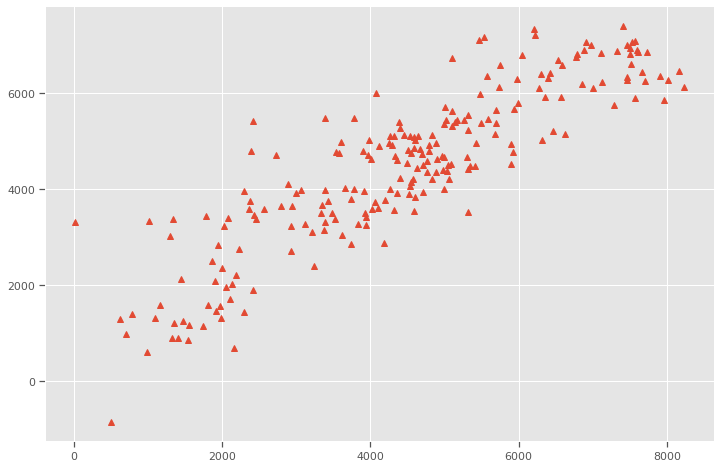

In [534]:
plt.plot(y_test, y_predict, '^')

###  Based on accuracy of 77% and the linear graph above we can say this final_model has good fit for predicting values

In [535]:
k = X_test.shape[1]
n = len(X_test)

# KPI's 
MSE = mean_squared_error(y_test, y_predict)
RMSE = float(format(np.sqrt(MSE), '.3f'))
MAE = mean_absolute_error(y_test, y_predict)
Rsquare = r2_score(y_test, y_predict)
adj_rsquare = 1-(1-Rsquare)*(n-1)/(n-k-1)

print("MSE: ", MSE, "\nRMSE: ", RMSE, '\nMAE: ', MAE, '\nRsquare: ', Rsquare, '\nadj_rsquare: ', adj_rsquare)

MSE:  814604.3742900641 
RMSE:  902.554 
MAE:  695.6077142238383 
Rsquare:  0.7699763642997153 
adj_rsquare:  0.7589175356602785


> Overfitting
- As we have less variables < 10 independent variables, this model is not overfit by nature

##### All considered, lets draw the formulae for best fit line.

const              1621.119567
temp               4000.213246
yr                 2054.600412
windspeed          -322.938521
weathersit_snow   -2017.446146
season_spring     -1061.496405
season_winter       483.325064

$ count = 1621.11 + 4000.21  \times  temp + 2054.60  \times  yr - 322.93  \times windspeed - 2017.44 \times weathersit_snow - 1061.49 \times season_spring + 483.32 \times season_winter $
